In [1]:
#1
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define base project path
base_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data"

# Confirm directory listing
print("Files in data directory:")
print(os.listdir(base_path))


Mounted at /content/drive
Files in data directory:
['best_rf_model.pkl', 'X_train_final (1).npy', 'y_test_final (1).npy', 'y_train_final (1).npy', 'unsw_y_train_encoded.pkl', 'X_test_final (1).npy', 'unsw_X_train_encoded.pkl', 'unsw_scaler.pkl', 'X_train_final.npy', 'X_test_final.npy', 'y_train_final.npy', 'y_test_final.npy', 'final_scaler.pkl', 'final_rf_model (1).pkl', 'final_shap_explainer (1).pkl', 'NSL_KDD', 'UNSW_NB15', 'Unknown_Legacy', 'unsw_feature_names.pkl', 'final_rf_model.pkl', 'final_shap_explainer.pkl', 'UNSW_NB15.zip', 'hybrid']


In [2]:
#2 Load pretrained classifiers, SHAP explainer, and scalers (organized by dataset)
import joblib
import numpy as np
import os

# Updated base path (project-structured)
base_path = "/content/drive/MyDrive/NIDS_Project/NIDS_Data"
unsw_path = os.path.join(base_path, "UNSW_NB15")
nsl_path = os.path.join(base_path, "NSL_KDD")
hybrid_path = os.path.join(base_path, "hybrid")

# Load models
unsw_model = joblib.load(os.path.join(unsw_path, "final_rf_model.pkl"))  # UNSW RF
nsl_model = joblib.load(os.path.join(nsl_path, "best_rf_model.pkl"))     # NSL RF
# Load scalers
unsw_scaler = joblib.load(os.path.join(unsw_path, "unsw_scaler.pkl"))
nsl_scaler = joblib.load(os.path.join(nsl_path, "nslkdd_scaler.pkl"))

# Load SHAP explainer if exists
shap_path = os.path.join(unsw_path, "final_shap_explainer.pkl")
shap_explainer = joblib.load(shap_path) if os.path.exists(shap_path) else None

print("Models and scalers loaded.")


Models and scalers loaded.


In [3]:
#3 Load NSL-KDD (CSV) and UNSW (NPY) datasets
# Purpose: Prepare feature and label arrays for model fusion and comparison

import pandas as pd
import numpy as np

# Load NSL-KDD CSV data from the NSL_KDD subfolder
nslkdd_X_train = pd.read_csv(os.path.join(nsl_path, "nslkdd_X_train.csv")).values
nslkdd_X_test  = pd.read_csv(os.path.join(nsl_path, "nslkdd_X_test.csv")).values
nslkdd_y_train = pd.read_csv(os.path.join(nsl_path, "nslkdd_y_train.csv")).values.ravel()
nslkdd_y_test  = pd.read_csv(os.path.join(nsl_path, "nslkdd_y_test.csv")).values.ravel()

# Load UNSW-NB15 data in NumPy format from the UNSW_NB15 subfolder
unsw_X_train = np.load(os.path.join(unsw_path, "unsw_X_train_final.npy"))
unsw_X_test  = np.load(os.path.join(unsw_path, "unsw_X_test_final.npy"))
unsw_y_train = np.load(os.path.join(unsw_path, "unsw_y_train_final.npy"))
unsw_y_test  = np.load(os.path.join(unsw_path, "unsw_y_test_final.npy"))

# Verify shapes for sanity check
print("NSL-KDD Shapes:")
print("  X_train:", nslkdd_X_train.shape, "| y_train:", nslkdd_y_train.shape)
print("  X_test :", nslkdd_X_test.shape,  "| y_test :", nslkdd_y_test.shape)

print("\nUNSW Shapes:")
print("  X_train:", unsw_X_train.shape,   "| y_train:", unsw_y_train.shape)
print("  X_test :", unsw_X_test.shape,    "| y_test :", unsw_y_test.shape)

NSL-KDD Shapes:
  X_train: (88180, 41) | y_train: (88180,)
  X_test : (37792, 41) | y_test : (37792,)

UNSW Shapes:
  X_train: (175341, 34) | y_train: (175341,)
  X_test : (82332, 34) | y_test : (82332,)


In [4]:
#4 Normalize Features Only (labels already encoded)
# Purpose: Align formats across NSL-KDD and UNSW for combined modeling

from sklearn.preprocessing import MinMaxScaler

# === Normalize Features ===
scaler_nslkdd = MinMaxScaler()
nslkdd_X_train_scaled = scaler_nslkdd.fit_transform(nslkdd_X_train)
nslkdd_X_test_scaled  = scaler_nslkdd.transform(nslkdd_X_test)

scaler_unsw = MinMaxScaler()
unsw_X_train_scaled = scaler_unsw.fit_transform(unsw_X_train)
unsw_X_test_scaled  = scaler_unsw.transform(unsw_X_test)

# Confirm shapes and label distributions
print("Normalized and Encoded Datasets Ready")
print("NSL-KDD: ", nslkdd_X_train_scaled.shape, "| Labels:", np.unique(nslkdd_y_train, return_counts=True))
print("UNSW   : ", unsw_X_train_scaled.shape,    "| Labels:", np.unique(unsw_y_train, return_counts=True))

Normalized and Encoded Datasets Ready
NSL-KDD:  (88180, 41) | Labels: (array([0, 1]), array([47328, 40852]))
UNSW   :  (175341, 34) | Labels: (array([0, 1], dtype=int32), array([ 56000, 119341]))


In [5]:
#5 Predict probabilities for fusion input
unsw_probs = unsw_model.predict_proba(unsw_X_test_scaled)[:, 1]
nsl_probs  = nsl_model.predict_proba(nslkdd_X_test_scaled)[:, 1]

# Fusion features: [UNSW_prob, NSL_prob]
fusion_X = np.vstack([
    np.column_stack([unsw_probs, np.zeros_like(unsw_probs)]),
    np.column_stack([np.zeros_like(nsl_probs), nsl_probs])
])

fusion_y = np.concatenate([unsw_y_test, nslkdd_y_test])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [6]:
#6 Train Meta-Classifier for Fusion (Stacked Model)
# Purpose: Learn how to combine model outputs for final prediction
# Context: Fusion of Random Forest (UNSW) and XGBoost (NSL-KDD)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Split fusion dataset for training and testing (e.g. 80/20)
fusion_X_train, fusion_X_test, fusion_y_train, fusion_y_test = train_test_split(
    fusion_X, fusion_y, test_size=0.2, stratify=fusion_y, random_state=42
)

# Train meta-classifier
fusion_meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
fusion_meta_model.fit(fusion_X_train, fusion_y_train)

# Predict and evaluate
fusion_preds = fusion_meta_model.predict(fusion_X_test)
fusion_probs = fusion_meta_model.predict_proba(fusion_X_test)[:, 1]

print("=== Fusion Classifier Evaluation ===")
print("Accuracy:", accuracy_score(fusion_y_test, fusion_preds))
print("Classification Report:\n", classification_report(fusion_y_test, fusion_preds))
print("Confusion Matrix:\n", confusion_matrix(fusion_y_test, fusion_preds))

=== Fusion Classifier Evaluation ===
Accuracy: 0.9437252861602498
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     11403
           1       0.96      0.93      0.95     12622

    accuracy                           0.94     24025
   macro avg       0.94      0.94      0.94     24025
weighted avg       0.94      0.94      0.94     24025

Confusion Matrix:
 [[10933   470]
 [  882 11740]]


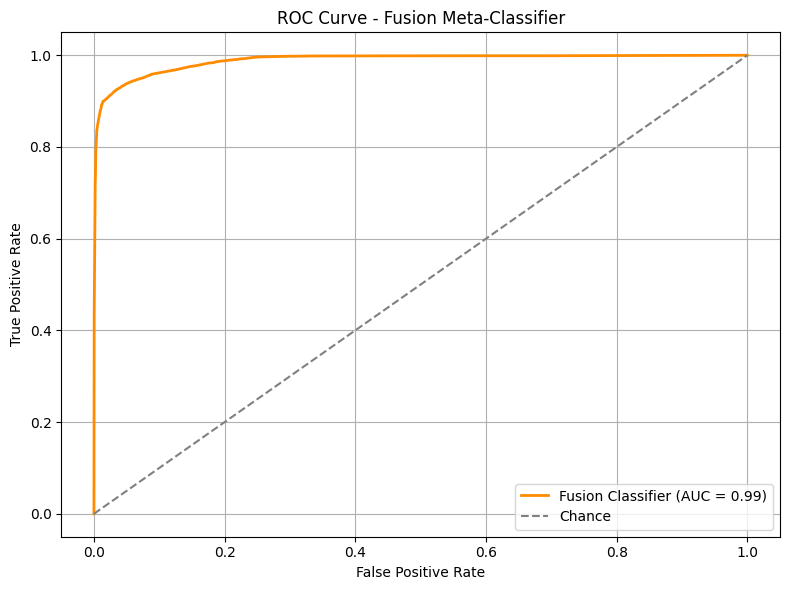

In [7]:
#7 ROC Curve for Fusion Classifier

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(fusion_y_test, fusion_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Fusion Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
plt.title("ROC Curve - Fusion Meta-Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
#8
print("=== Shape and Label Alignment Check ===")
print("NSL-KDD X shape:", nslkdd_X_train_scaled.shape, "+", nslkdd_X_test_scaled.shape)
print("NSL-KDD y shape:", nslkdd_y_train.shape, "+", nslkdd_y_test.shape)

print("UNSW X shape:", unsw_X_train_scaled.shape, "+", unsw_X_test_scaled.shape)
print("UNSW y shape:", unsw_y_train.shape, "+", unsw_y_test.shape)

print("Fusion X shape:", fusion_X.shape)
print("Fusion y shape:", fusion_y.shape)

=== Shape and Label Alignment Check ===
NSL-KDD X shape: (88180, 41) + (37792, 41)
NSL-KDD y shape: (88180,) + (37792,)
UNSW X shape: (175341, 34) + (82332, 34)
UNSW y shape: (175341,) + (82332,)
Fusion X shape: (120124, 2)
Fusion y shape: (120124,)


In [9]:
#9
print("=== Sample Fusion Input Verification ===")
print("First 5 fusion rows:\n", fusion_X[:5])
print("Should contain only [0, p] and [p, 0] style rows")

print("\nUnique column 0 values (NSL marker):", np.unique(fusion_X[:, 0]))
print("Unique column 1 values (UNSW marker):", np.unique(fusion_X[:, 1]))


=== Sample Fusion Input Verification ===
First 5 fusion rows:
 [[0.84       0.        ]
 [0.84       0.        ]
 [0.39113994 0.        ]
 [0.47       0.        ]
 [0.64702381 0.        ]]
Should contain only [0, p] and [p, 0] style rows

Unique column 0 values (NSL marker): [0.         0.00125    0.00166667 0.00278409 0.00333333 0.004
 0.00461032 0.005      0.00543924 0.00666667 0.01       0.013
 0.015      0.0154697  0.01659524 0.01714286 0.01733333 0.01833333
 0.01993573 0.02       0.02044444 0.02416671 0.025      0.03
 0.03206349 0.03475296 0.03666667 0.0399527  0.04       0.04364752
 0.04490867 0.0455737  0.04813993 0.04825381 0.05       0.0525
 0.05313816 0.05464547 0.05511147 0.05583333 0.05606063 0.0560867
 0.05666667 0.06       0.06133333 0.0637358  0.06420962 0.06435916
 0.065      0.06666667 0.06943939 0.07       0.07066395 0.07084595
 0.07136364 0.07255131 0.07503446 0.077      0.07834127 0.08
 0.08386364 0.08452705 0.08528836 0.087142   0.0875     0.08829964
 0.09       0.

In [10]:
#10
print("=== Check Fusion Labels Source ===")
print("NSL test labels shape:", nslkdd_y_test.shape)
print("UNSW test labels shape:", unsw_y_test.shape)
print("Fusion y shape:", fusion_y.shape)

# Check label class distribution
print("\nClass counts in Fusion labels:")
(unique, counts) = np.unique(fusion_y, return_counts=True)
print(dict(zip(unique, counts)))

=== Check Fusion Labels Source ===
NSL test labels shape: (37792,)
UNSW test labels shape: (82332,)
Fusion y shape: (120124,)

Class counts in Fusion labels:
{np.int64(0): np.int64(57014), np.int64(1): np.int64(63110)}


In [11]:
#11
from sklearn.model_selection import train_test_split

# Re-split fusion_X and fusion_y, stratify ensures class balance
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    fusion_X, fusion_y, test_size=0.2, random_state=42, stratify=fusion_y)

print("Train fusion shape:", X_temp_train.shape, "| Labels:", y_temp_train.shape)
print("Test fusion shape:", X_temp_test.shape, "| Labels:", y_temp_test.shape)

# No overlap means no leakage
intersection = np.intersect1d(X_temp_train.view([('', X_temp_train.dtype)]).flatten(),
                              X_temp_test.view([('', X_temp_test.dtype)]).flatten())
print("\nOverlap in training/test fusion input rows:", len(intersection))

Train fusion shape: (96099, 2) | Labels: (96099,)
Test fusion shape: (24025, 2) | Labels: (24025,)

Overlap in training/test fusion input rows: 621


In [12]:
#12
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train a dummy classifier (always predicts majority class)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(fusion_X_train, fusion_y_train)

# Predict and evaluate
dummy_preds = dummy_clf.predict(fusion_X_test)
dummy_proba = dummy_clf.predict_proba(fusion_X_test)[:, 1]

print("=== Dummy Classifier Evaluation ===")
print("Accuracy:", accuracy_score(fusion_y_test, dummy_preds))
print("AUC:", roc_auc_score(fusion_y_test, dummy_proba))
print("Classification Report:\n", classification_report(fusion_y_test, dummy_preds))

=== Dummy Classifier Evaluation ===
Accuracy: 0.525369406867846
AUC: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11403
           1       0.53      1.00      0.69     12622

    accuracy                           0.53     24025
   macro avg       0.26      0.50      0.34     24025
weighted avg       0.28      0.53      0.36     24025



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
#13
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# Train Isolation Forest (unsupervised anomaly detection)
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(fusion_X)

# Predict: -1 for anomaly, 1 for normal
anomaly_preds = iso_forest.predict(fusion_X)

# Convert to binary labels: 1 = attack (anomaly), 0 = benign
anomaly_labels = np.where(anomaly_preds == -1, 1, 0)

# Evaluate against actual labels
print("=== Isolation Forest Anomaly Detection ===")
print(classification_report(fusion_y, anomaly_labels, target_names=["Benign", "Attack"]))

=== Isolation Forest Anomaly Detection ===
              precision    recall  f1-score   support

      Benign       0.47      0.89      0.62     57014
      Attack       0.49      0.09      0.16     63110

    accuracy                           0.47    120124
   macro avg       0.48      0.49      0.39    120124
weighted avg       0.48      0.47      0.38    120124



In [14]:
# 13.6: One-Class SVM for Anomaly Detection
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# Train One-Class SVM only on benign samples
X_benign = fusion_X[fusion_y == 0]

svm_model = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
svm_model.fit(X_benign)

# Predict on the full dataset
svm_raw_preds = svm_model.predict(fusion_X)  # Output: 1 (normal), -1 (anomaly)
svm_labels = np.where(svm_raw_preds == -1, 1, 0)  # Convert to: 1 = Attack, 0 = Benign

# Evaluate
print("=== One-Class SVM Anomaly Detection ===")
print("Classification Report:\n", classification_report(fusion_y, svm_labels, target_names=["Benign", "Attack"]))
print("Confusion Matrix:\n", confusion_matrix(fusion_y, svm_labels))

=== One-Class SVM Anomaly Detection ===
Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.73      0.81     57014
      Attack       0.79      0.92      0.85     63110

    accuracy                           0.83    120124
   macro avg       0.84      0.83      0.83    120124
weighted avg       0.84      0.83      0.83    120124

Confusion Matrix:
 [[41691 15323]
 [ 4834 58276]]


In [15]:
#13.5 Bayesian Gaussian Mixture Model for anomaly detection
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import mode

bgmm = BayesianGaussianMixture(n_components=2, covariance_type='full', random_state=42)
bgmm.fit(fusion_X_train)

# Predict cluster assignments
bgmm_preds = np.argmax(bgmm.predict_proba(fusion_X_test), axis=1)

# Map cluster to label using majority voting on training data
cluster_labels = np.zeros(2)

for cluster in [0, 1]:
    cluster_indices = (bgmm.predict(fusion_X_train) == cluster)
    majority_label = mode(fusion_y_train[cluster_indices], keepdims=True).mode[0]
    cluster_labels[cluster] = majority_label

# Map predictions to true labels
mapped_preds = cluster_labels[bgmm_preds.astype(int)]

# Evaluate
print("=== Bayesian GMM Anomaly Detection ===")
print(classification_report(fusion_y_test, mapped_preds, target_names=["Benign", "Attack"]))

=== Bayesian GMM Anomaly Detection ===
              precision    recall  f1-score   support

      Benign       0.55      0.98      0.70     11403
      Attack       0.93      0.28      0.43     12622

    accuracy                           0.61     24025
   macro avg       0.74      0.63      0.57     24025
weighted avg       0.75      0.61      0.56     24025



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


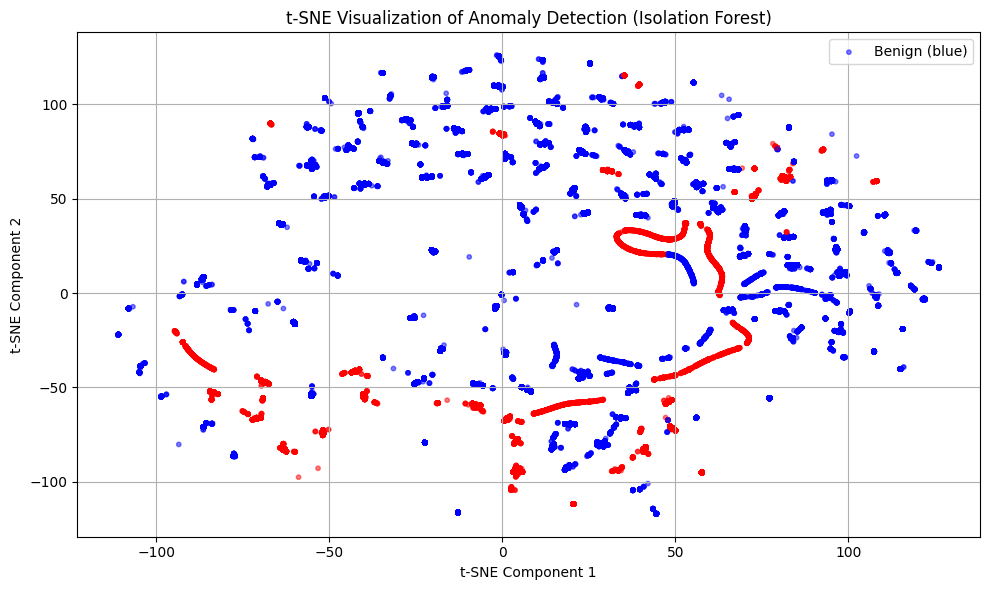

In [16]:
#14
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
fusion_X_2D = tsne.fit_transform(fusion_X)

# Plot anomaly vs normal
plt.figure(figsize=(10, 6))
colors = ['blue' if label == 0 else 'red' for label in anomaly_labels]

plt.scatter(fusion_X_2D[:, 0], fusion_X_2D[:, 1], c=colors, alpha=0.5, s=10, label='Samples')
plt.title("t-SNE Visualization of Anomaly Detection (Isolation Forest)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(["Benign (blue)", "Anomaly (red)"])
plt.grid(True)
plt.tight_layout()
plt.show()

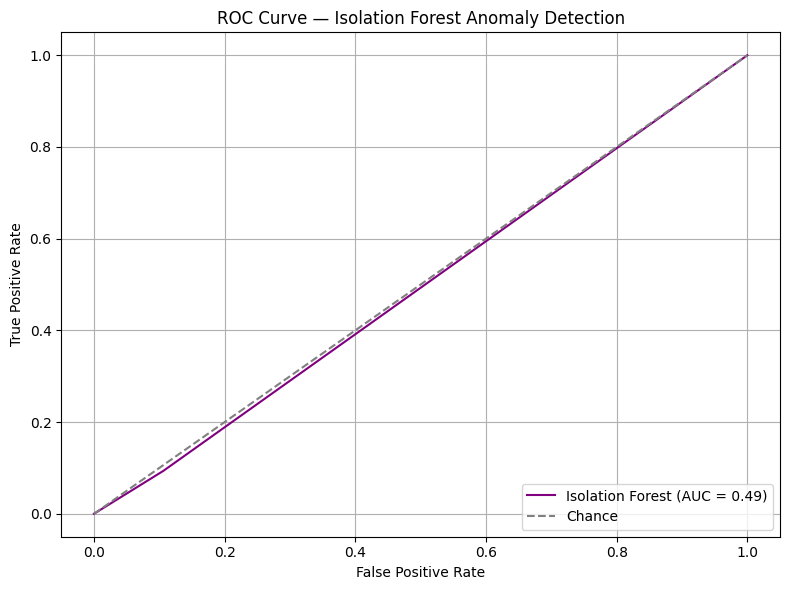

In [17]:
# 14.5: ROC Curve for Isolation Forest Anomaly Detection
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Isolation Forest predictions are already converted to binary: anomaly_labels (1 = attack, 0 = benign)

# Compute ROC curve and AUC
fpr_iso, tpr_iso, _ = roc_curve(fusion_y, anomaly_labels)
auc_iso = auc(fpr_iso, tpr_iso)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_iso, tpr_iso, label=f'Isolation Forest (AUC = {auc_iso:.2f})', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance')
plt.title('ROC Curve — Isolation Forest Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
#15 Build and Train an Autoencoder for Unsupervised Anomaly Detection
# Purpose: Learn normal behavior patterns and flag high reconstruction errors as anomalies

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

# Normalize input again (Autoencoders are sensitive to scale)
scaler_auto = MinMaxScaler()
fusion_X_scaled = scaler_auto.fit_transform(fusion_X)

# Define Autoencoder model
input_dim = fusion_X_scaled.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train only on "normal" traffic (label 0)
normal_data = fusion_X_scaled[fusion_y == 0]

# Train autoencoder
history = autoencoder.fit(
    normal_data, normal_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1395 - val_loss: 0.0121
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 8.1279e-04
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4850e-04 - val_loss: 6.1015e-04
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6465e-04 - val_loss: 4.9619e-04
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1576e-04 - val_loss: 4.4421e-04
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7917e-04 - val_loss: 4.1569e-04
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7635e-04 - val_loss: 3.9564e-04
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6260e-04 - val_loss: 3.9167e-04
Epoch 9/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5143e-04 - val_loss: 3.7944e-04
Epoch 10/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3883e-04 - val_loss: 3.4154e-04
Epoch 11/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5674e-04

In [19]:
#16
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Reconstruct test samples
X_reconstructed = autoencoder.predict(fusion_X_test)

# Step 2: Compute Mean Squared Error (MSE) per sample
reconstruction_errors = np.mean(np.square(fusion_X_test - X_reconstructed), axis=1)

# Step 3: Define threshold for anomaly
# This can be tuned; for now we use the 95th percentile of training reconstruction errors
X_train_reconstructed = autoencoder.predict(fusion_X_train)
train_errors = np.mean(np.square(fusion_X_train - X_train_reconstructed), axis=1)
threshold = np.percentile(train_errors, 95)

# Step 4: Classify: 1 = anomaly (attack), 0 = normal
predicted_anomalies = (reconstruction_errors > threshold).astype(int)

# Step 5: Report
print("=== Autoencoder Anomaly Detection ===")
print("Threshold (95th percentile):", threshold)
print("Reconstruction Error Stats: min =", reconstruction_errors.min(), "max =", reconstruction_errors.max())

# Confusion matrix and classification report
print("\nClassification Report:")
print(classification_report(y_temp_test, predicted_anomalies, target_names=["Benign", "Attack"]))

print("Confusion Matrix:")
print(confusion_matrix(y_temp_test, predicted_anomalies))

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 3s 998us/step
=== Autoencoder Anomaly Detection ===
Threshold (95th percentile): 0.09418206800752849
Reconstruction Error Stats: min = 5.094595081422693e-10 max = 0.09418206800752849

Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      1.00      0.64     11403
      Attack       0.00      0.00      0.00     12622

    accuracy                           0.47     24025
   macro avg       0.24      0.50      0.32     24025
weighted avg       0.23      0.47      0.31     24025

Confusion Matrix:
[[11403     0]
 [12622     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
#17 Filter benign samples from training set (label 0)
X_benign_train = fusion_X_train[y_temp_train == 0]

# Define autoencoder again (same architecture as before)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Sequential

autoencoder = Sequential([
    Dense(8, activation='relu', input_shape=(fusion_X.shape[1],)),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(fusion_X.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train only on benign data
history = autoencoder.fit(
    X_benign_train, X_benign_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1686 - val_loss: 0.0525
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.0165
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0030
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3086e-04 - val_loss: 8.8178e-04
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7816e-04 - val_loss: 7.6722e-04
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8200e-04 - val_loss: 6.6432e-04
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6790e-04 - val_loss: 5.5173e-04
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4891e-04 - val_loss: 4.6013e-04
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8482e-04 - val_loss: 3.9799e-04
Epoch 12/50
143

In [21]:
#18
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Reconstruct test input ===
reconstructions = autoencoder.predict(fusion_X_test)

# === 2. Compute reconstruction error ===
reconstruction_errors = np.mean(np.square(fusion_X_test - reconstructions), axis=1)

# === 3. Determine anomaly threshold from training benign errors ===
recon_benign = autoencoder.predict(X_benign_train)
benign_errors = np.mean(np.square(X_benign_train - recon_benign), axis=1)
threshold = np.percentile(benign_errors, 95)

print("Anomaly threshold (95th percentile of benign error):", threshold)

# === 4. Classify as anomaly if error > threshold ===
predicted_anomalies = (reconstruction_errors > threshold).astype(int)  # 1 = anomaly (attack), 0 = benign

# === 5. Evaluate ===
print("\n=== Evaluation on Fusion Test Set ===")
print("Confusion Matrix:\n", confusion_matrix(fusion_y_test, predicted_anomalies))
print("\nClassification Report:\n", classification_report(fusion_y_test, predicted_anomalies, target_names=["Benign", "Attack"]))

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1426/1426 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step
Anomaly threshold (95th percentile of benign error): 8.896947774813642e-05

=== Evaluation on Fusion Test Set ===
Confusion Matrix:
 [[10835   568]
 [ 1189 11433]]

Classification Report:
               precision    recall  f1-score   support

      Benign       0.90      0.95      0.93     11403
      Attack       0.95      0.91      0.93     12622

    accuracy                           0.93     24025
   macro avg       0.93      0.93      0.93     24025
weighted avg       0.93      0.93      0.93     24025



In [22]:
#19 Run a dummy forward pass to initialize the model (won't train)
_ = autoencoder.predict(fusion_X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [23]:
#20
autoencoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356 (1.39 KB)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 238 (956.00 B)

In [24]:
#21
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(fusion_X_train.shape[1],))

# Encoder
encoded = Dense(8, activation='relu')(input_layer)
bottleneck = Dense(4, activation='relu', name="bottleneck")(encoded)

# Decoder
decoded = Dense(8, activation='relu')(bottleneck)
output_layer = Dense(2, activation='sigmoid')(decoded)

# Define the functional autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Recompile
autoencoder.compile(optimizer='adam', loss='mse')

In [25]:
#22
from tensorflow.keras.models import Model

# Create a model that outputs the bottleneck layer's activations
encoder_model = Model(inputs=autoencoder.input,
                      outputs=autoencoder.get_layer("bottleneck").output)

# Get encoded feature representations for the test set
encoded_features = encoder_model.predict(fusion_X_test)
print("Encoded features shape:", encoded_features.shape)

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step
Encoded features shape: (24025, 4)


In [26]:
#23
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define better encoder-decoder architecture
input_dim = fusion_X.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(16, activation='relu')(input_layer)
bottleneck = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Assemble model
deep_autoencoder = Model(inputs=input_layer, outputs=output_layer)
deep_autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

deep_autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362 (1.41 KB)

 Trainable params: 362 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#24 Train with validation
history = deep_autoencoder.fit(
    fusion_X, fusion_X,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1236 - val_loss: 0.0086
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.2281e-04 - val_loss: 9.1505e-04
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2039e-04 - val_loss: 7.7806e-04
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8358e-04 - val_loss: 6.9210e-04
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5056e-04 - val_loss: 5.8375e-04
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2344e-04 - val_loss: 5.9194e-04
Epoch 8/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6171e-04 - val_loss: 5.5073e-04
Epoch 9/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7201e-04 - val_loss: 4.8621e-04
Epoch 10/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6821e-04 - val_loss: 4.0259e-04
Epoch 11/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8475e-04 - v

In [28]:
#25
from tensorflow.keras.models import Model

# Extract the encoder part from the deep autoencoder
encoder_model = Model(
    inputs=deep_autoencoder.input,
    outputs=deep_autoencoder.get_layer(index=3).output  # bottleneck layer
)

# Encode the test data
encoded_features = encoder_model.predict(fusion_X_test)

print("Encoded features shape:", encoded_features.shape)

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Encoded features shape: (24025, 16)


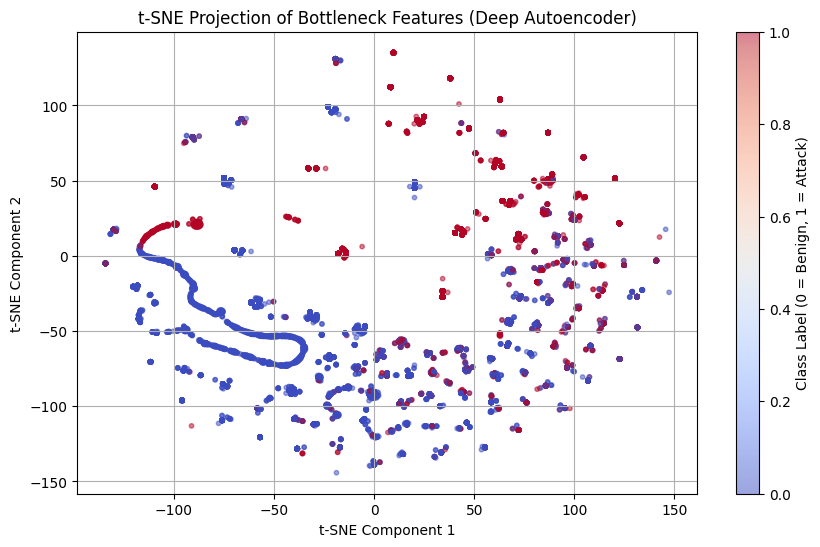

In [29]:
#26
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_result = tsne.fit_transform(encoded_features)

# Plot t-SNE with labels
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                      c=fusion_y_test, cmap='coolwarm', alpha=0.5, s=10)
plt.title("t-SNE Projection of Bottleneck Features (Deep Autoencoder)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Add colorbar for clarity
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label (0 = Benign, 1 = Attack)")
plt.grid(True)
plt.show()

In [30]:
#27
from sklearn.metrics import confusion_matrix, classification_report

# Compute reconstruction errors
reconstructions = deep_autoencoder.predict(fusion_X_test)
mse = np.mean(np.square(reconstructions - fusion_X_test), axis=1)

# Set threshold using 95th percentile of benign training error
threshold = np.percentile(mse[fusion_y_test == 0], 95)

# Predict anomalies (1 = anomaly if above threshold)
predicted_anomalies = (mse > threshold).astype(int)

# Evaluate
print("=== Deep Autoencoder Anomaly Detection ===")
print(f"Threshold (95th percentile of benign error): {threshold}")
print("\nConfusion Matrix:\n", confusion_matrix(fusion_y_test, predicted_anomalies))
print("\nClassification Report:\n", classification_report(fusion_y_test, predicted_anomalies, target_names=["Benign", "Attack"]))

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
=== Deep Autoencoder Anomaly Detection ===
Threshold (95th percentile of benign error): 0.00019493325410448469

Confusion Matrix:
 [[10844   559]
 [12406   216]]

Classification Report:
               precision    recall  f1-score   support

      Benign       0.47      0.95      0.63     11403
      Attack       0.28      0.02      0.03     12622

    accuracy                           0.46     24025
   macro avg       0.37      0.48      0.33     24025
weighted avg       0.37      0.46      0.31     24025



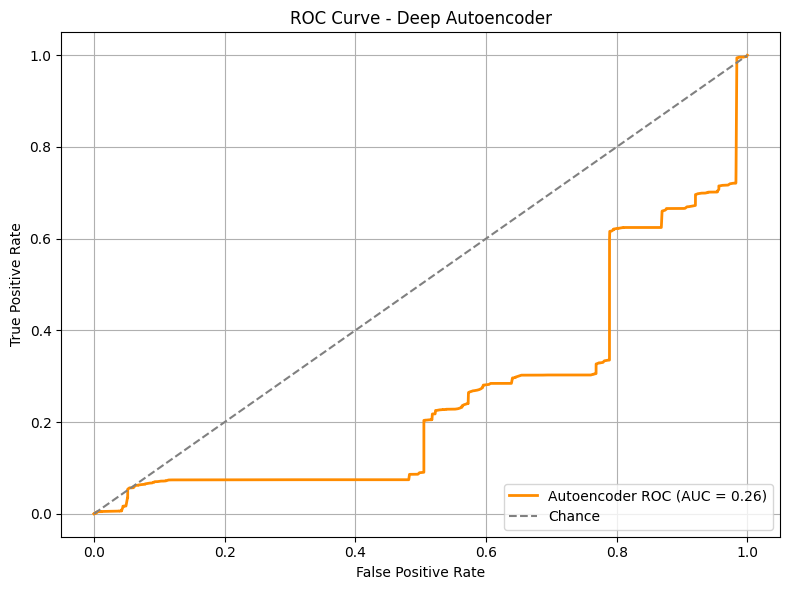

In [31]:
#28
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Re-use previously calculated reconstruction error `mse`
fpr, tpr, thresholds = roc_curve(fusion_y_test, mse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Autoencoder ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Deep Autoencoder")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
#29
import numpy as np

# === Get predictions from both models ===

# Supervised prediction (binary)
fusion_preds = fusion_meta_model.predict(fusion_X_test)

# Autoencoder reconstruction
reconstructed = deep_autoencoder.predict(fusion_X_test)

# Reconstruction error (MSE per sample)
reconstruction_errors = np.mean(np.square(fusion_X_test - reconstructed), axis=1)

751/751 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [33]:
#30 === Apply anomaly detection threshold ===

# Use only benign samples to define threshold
benign_mask = fusion_y_test == 0
benign_errors = reconstruction_errors[benign_mask]

# Set threshold at 95th percentile of benign errors
anomaly_threshold = np.percentile(benign_errors, 95)

# Create binary anomaly predictions
anomaly_preds = (reconstruction_errors > anomaly_threshold).astype(int)

print("Anomaly threshold:", anomaly_threshold)

Anomaly threshold: 0.00019493325410448469


In [34]:
#31 === Final Fusion Decision ===

# Use existing predictions from binary classifier and autoencoder
# (Assuming: `fusion_preds` from earlier and `anomaly_preds` from previous cell)

# Fusion logic: flag as attack if *either* model predicts attack
hybrid_preds = np.logical_or(fusion_preds, anomaly_preds).astype(int)

# Evaluate
print("=== Hybrid NIDS Evaluation ===")
print("Confusion Matrix:\n", confusion_matrix(fusion_y_test, hybrid_preds))
print("\nClassification Report:\n", classification_report(fusion_y_test, hybrid_preds, target_names=["Benign", "Attack"]))

=== Hybrid NIDS Evaluation ===
Confusion Matrix:
 [[10396  1007]
 [  864 11758]]

Classification Report:
               precision    recall  f1-score   support

      Benign       0.92      0.91      0.92     11403
      Attack       0.92      0.93      0.93     12622

    accuracy                           0.92     24025
   macro avg       0.92      0.92      0.92     24025
weighted avg       0.92      0.92      0.92     24025



In [35]:
#32 Save final hybrid models
import os
from tensorflow.keras.models import save_model
os.makedirs(hybrid_path, exist_ok=True)

joblib.dump(fusion_meta_model, os.path.join(hybrid_path, "fusion_meta_model.pkl"))
save_model(deep_autoencoder, os.path.join(hybrid_path, "deep_autoencoder_model.h5"))

with open(os.path.join(hybrid_path, "anomaly_threshold.txt"), 'w') as f:
    f.write(str(anomaly_threshold))

print("Saved fusion model, autoencoder, and threshold to:", hybrid_path)

Saved fusion model, autoencoder, and threshold to: /content/drive/MyDrive/NIDS_Project/NIDS_Data/hybrid


In [36]:
#33
from tensorflow.keras.models import load_model
import tensorflow.keras.losses

# Fix for loading with correct custom loss (no compile)
autoencoder_model = load_model(
    os.path.join(hybrid_path, 'deep_autoencoder_model.h5'),
    compile=False
)

# Load saved anomaly detection threshold
with open(os.path.join(hybrid_path, 'anomaly_threshold.txt'), 'r') as f:
    anomaly_threshold = float(f.read())

In [37]:
#34. Updated hybrid prediction function
def hybrid_nids_predict(sample, fusion_model, autoencoder_model, threshold):
    """
    Predicts if a sample is malicious using both classification and anomaly detection.
    Returns detailed decisions and metrics.
    """
    sample = sample.reshape(1, -1)

    # Classifier decision
    class_pred = fusion_model.predict(sample)
    class_decision = int(class_pred[0])  # fusion model is a RF classifier

    # Autoencoder decision
    recon = autoencoder_model.predict(sample)
    recon_error = np.mean(np.square(sample - recon))
    anomaly_decision = int(recon_error > threshold)

    verdict = int(class_decision or anomaly_decision)

    return {
        'classifier_attack': class_decision,
        'anomaly_attack': anomaly_decision,
        'verdict': verdict,
        'reconstruction_error': recon_error
    }

In [38]:
#35. Predict and evaluate hybrid system
print("=== Hybrid NIDS Predictions ===")
test_samples = fusion_X_test
true_labels = fusion_y_test

for i in range(5):
    result = hybrid_nids_predict(test_samples[i], fusion_meta_model, deep_autoencoder, anomaly_threshold)
    print(f"\nSample {i+1}")
    print(f"True Label         : {true_labels[i]}")
    print(f"Classifier detects : {result['classifier_attack']}")
    print(f"Anomaly detects    : {result['anomaly_attack']}")
    print(f"Final Verdict      : {result['verdict']}")
    print(f"Reconstruction Err : {result['reconstruction_error']:.4f}")

=== Hybrid NIDS Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Sample 1
True Label         : 1
Classifier detects : 1
Anomaly detects    : 0
Final Verdict      : 1
Reconstruction Err : 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Sample 2
True Label         : 0
Classifier detects : 0
Anomaly detects    : 0
Final Verdict      : 0
Reconstruction Err : 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sample 3
True Label         : 1
Classifier detects : 1
Anomaly detects    : 0
Final Verdict      : 1
Reconstruction Err : 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sample 4
True Label         : 0
Classifier detects : 0
Anomaly detects    : 0
Final Verdict      : 0
Reconstruction Err : 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Sample 5
True Label         : 0
Classifier detects : 0
Anomaly detects    : 0
Final Verdict      : 0
Reconstruction Err : 0.0001
